# Imports

Cleaning the input to ensure review is a string and not null, lowercase, no URL and no non-alphabetic characters, no stop words, lemmatizing the words, keeping only valid English words.

We are also filtering the reviews which are short that may lack enough information and long ones may be harder to process efficiently.

In [ ]:
import pandas as pd
import re
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
import nltk
from nltk.corpus import words
from nltk.stem import WordNetLemmatizer

nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('words')

# lemmatizer
lemmatizer = WordNetLemmatizer()
english_words_set = set(words.words())

def clean_text(text):
    # Check for NaN and string
    if not isinstance(text, str) or pd.isnull(text):
        return None
    text = text.lower()
    text = re.sub(r'http\S+|www.\S+', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = re.sub(r'[^\w\s]', '', text)

    # Tokenize and lemmatize
    tokens = text.split()
    lemmatized_tokens = [lemmatizer.lemmatize(word) for word in tokens if word in english_words_set]

    # Remove stopwords
    cleaned_words = [
        word for word in lemmatized_tokens if word not in ENGLISH_STOP_WORDS
    ]
    cleaned_text = " ".join(cleaned_words)

    # keep sentences with more than 10 words or less than 50 words
    word_count = len(cleaned_words)
    if word_count < 10 or word_count > 50:
        return None
    return cleaned_text

# Load the data
data_url = '/content/rotten_tomatoes_critic_reviews.csv'
review_raw_df = pd.read_csv(data_url).iloc[:90000]
review = review_raw_df['review_content']
review_cleaned = review.apply(clean_text).dropna()

print(review_cleaned.head())

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!


3     lightning thief hard predict overall entertain...
10    fantasy adventure based rick hit series great ...
12    comfort zone mirthless episodic fantasy saga b...
16    perfectly inoffensive occasionally clever genu...
19    movie slows catch breath little heart soul wry...
Name: review_content, dtype: object


In [ ]:
# count of total sentences in review_cleaned
sentence_counts = review_cleaned.str.split('.').str.len()
print(f"Total number of sentences: {sentence_counts.sum()}")

Total number of sentences: 22880


# Embedding

## Sentence-BERT

BERT is great at understanding the context of words in a sentence but it does not directly give embeddings for complete sentences. Sentence-BERT generate sentence-level embeddings, making it suitable for tasks like text clustering and information retrieval.

all-MiniLM-L6-v2 is a pre-trained Sentence-BERT model. MiniLM models are smaller and faster and provides high quality sentence embeddings.


In [ ]:
import numpy as np
from sentence_transformers import SentenceTransformer
# Sentence-BERT model
model = SentenceTransformer('all-MiniLM-L6-v2')

# Sentence embeddings
embeddings = model.encode(review_cleaned.tolist(), show_progress_bar=True)

# Embeddings to  DataFrame
embeddings = pd.DataFrame(np.array(embeddings))
print("Shape of sentence embeddings:", embeddings.shape)


Batches:   0%|          | 0/715 [00:00<?, ?it/s]

Shape of sentence embeddings: (22880, 384)


## Simple Bart model

BERT (Bidirectional Encoder Representations from Transformers)

In [ ]:
# !pip install torch==2.5.0 torch_xla==2.5.0

from transformers import BertTokenizer, BertModel

import torch
import torch_xla
import torch_xla.core.xla_model as xm

# Load BERT model and tokenizer
# tokenizer = BartTokenizer.from_pretrained('facebook/bart-large')
# model = BartModel.from_pretrained('facebook/bart-large')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

# Sentence embeddings
def get_bart_embeddings(text):
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True)
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).squeeze().cpu().numpy()

# Embeddings
embeddings = [get_bart_embeddings(sentence) for sentence in review_cleaned]
embeddings = pd.DataFrame(np.array(embeddings))
print("Shape of sentence embeddings:", embeddings.shape)

## Universal Sentence Encoder

USE is a pre-trained model developed by Google.it  directly gives embeddings for whole sentences capturing their semantic meaning

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np

# Load the Universal Sentence Encoder
use_model_url = "https://tfhub.dev/google/universal-sentence-encoder/4"
embed = hub.load(use_model_url)

# Embeddings
embeddings = embed(list(review_cleaned))

# Embeddings to a DF
embeddings_array = np.array(embeddings)
embeddings = pd.DataFrame(embeddings_array)
print("Shape of sentence embeddings:", embeddings.shape)


Shape of sentence embeddings: (22880, 512)


# K-means
To group reviews into clusters based on semantic similarity we used k-means clustering.

Performed clustering with the optimal k determined using Inertia and Silhouette Scores. Assigned labels to each review, indicating which cluster it belongs to.

In [ ]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
!pip install kneed
from kneed import KneeLocator
import numpy as np

## Find best k

Defined possible k values from 2 to 14.
Calculated the Sum of Squared Distances (Inertia) and Silhouette Scores.
Used KneeLocator to determine the optimal number of clusters and verified the optimal k value using the Silhouette Score.

<ipython-input-70-2509eb7eddc9>:21: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo-" (-> color='b'). The keyword argument will take precedence.
  ax1.plot(k_values, inertia, 'bo-', label='Inertia (Elbow)', color='b')
<ipython-input-70-2509eb7eddc9>:28: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro-" (-> color='r'). The keyword argument will take precedence.
  ax2.plot(k_values, silhouette_scores, 'ro-', label='Silhouette Score', color='r')


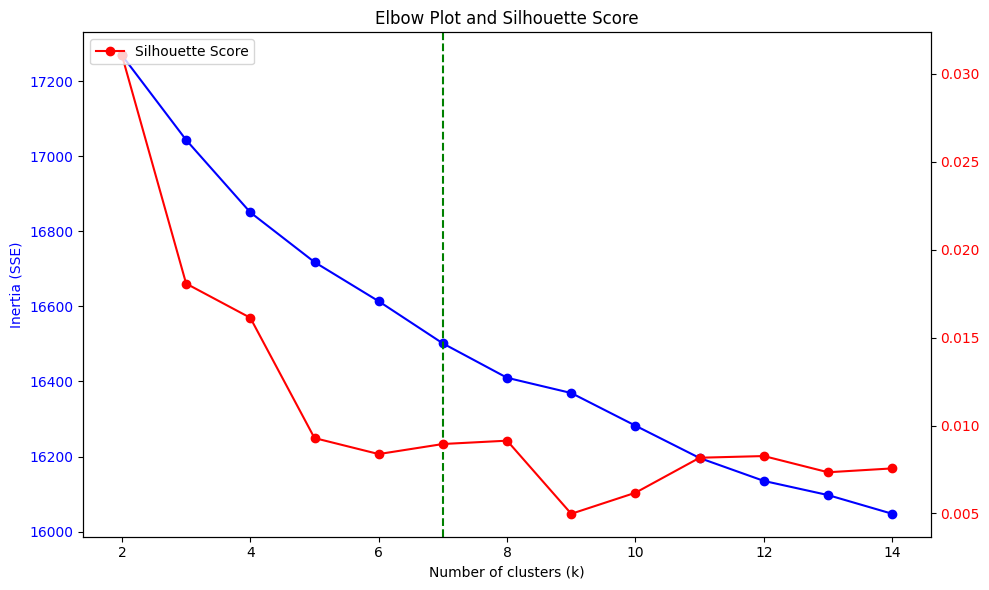

The optimal k on Elbow method is: 7


In [ ]:
k_values = range(2, 15)

# Calculate inertia (Elbow method) and silhouette scores
inertia = []
silhouette_scores = []
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(embeddings)
    inertia.append(kmeans.inertia_)
    score = silhouette_score(embeddings, kmeans.labels_)
    silhouette_scores.append(score)

# KneeLocator to find the knee in elbow curve
knee_locator = KneeLocator(k_values, inertia, curve='convex', direction='decreasing')
optimal_k = knee_locator.knee

fig, ax1 = plt.subplots(figsize=(10, 6))
# Elbow plot - Inertia to Left y-axis
ax1.plot(k_values, inertia, 'bo-', label='Inertia (Elbow)', color='b')
ax1.set_xlabel('Number of clusters (k)')
ax1.set_ylabel('Inertia (SSE)', color='b')
ax1.tick_params(axis='y', labelcolor='b')

# Silhouette Score to Right y-axis
ax2 = ax1.twinx()
ax2.plot(k_values, silhouette_scores, 'ro-', label='Silhouette Score', color='r')
ax2.set_ylabel('Silhouette Score', color='r')
ax2.tick_params(axis='y', labelcolor='r')

ax1.axvline(x=optimal_k, color='g', linestyle='--', label=f'Optimal k (Elbow) = {optimal_k}')

# plot
plt.title('Elbow Plot and Silhouette Score')
fig.tight_layout()
plt.legend(loc='upper left')
plt.show()


print(f"The optimal k on Elbow method is: {optimal_k}")


In [ ]:
# KMeans with the optimal k
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans.fit(embeddings)
k_labels = kmeans.labels_
embeddings_array = np.array(embeddings)

## Plot
Using t-SNE we visually check how well reviews are separated into clusters in a 2D space. We reduced the high-dimensional embeddings to 2D using t-SNE and plotted reviews.

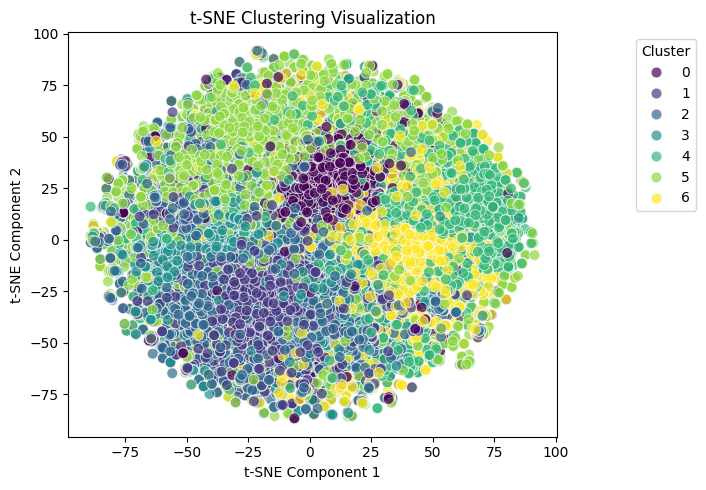

In [ ]:
# t-SNE
tsne = TSNE(n_components=2, random_state=42)
tsne_embeddings = tsne.fit_transform(embeddings_array)

# Plot
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.scatterplot(x=tsne_embeddings[:, 0], y=tsne_embeddings[:, 1], hue=k_labels, palette='viridis', s=60, alpha=0.7)
plt.title("t-SNE Clustering Visualization")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.legend(title="Cluster", loc='upper right', bbox_to_anchor=(1.3, 1))

plt.tight_layout()
plt.show()

## Word cloud
Word clouds display the most frequent words in each cluster helps to identify dominant themes or topics in the reviews. We used custom stopwords to filtering out irrelevant and common terms so we coluld focus on meaningful words.

Word clouds display the most frequent words in each cluster.helps to identify dominant themes or topics in the reviews. We used custom stopwords to filtering out irrelevant and common terms so we coluld focus on meaningful words.

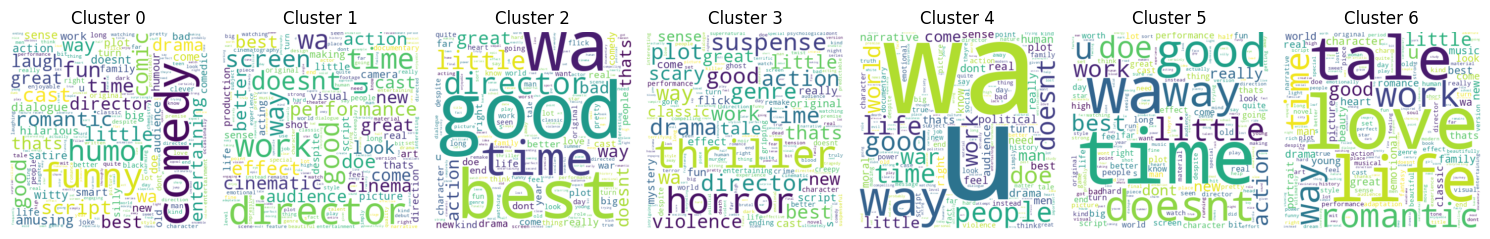

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter

# Define custom stopwords
custom_stopwords = {'like','film', 'movie','just','story','make'}

# Clustered reviews DataFrame
clustered_reviews = pd.DataFrame({'review': review_cleaned, 'cluster': k_labels})

# Create word clouds for each cluster
num_clusters = optimal_k
fig, axes = plt.subplots(1, num_clusters, figsize=(15, 6), sharex=True, sharey=True)

for cluster in range(num_clusters):
    cluster_reviews = clustered_reviews[clustered_reviews['cluster'] == cluster]['review']
    words = " ".join(cluster_reviews).split()
    word_freq = Counter(words)
    filtered_word_freq = {word: freq for word, freq in word_freq.items() if word not in custom_stopwords}
    wordcloud = WordCloud(width=400, height=400, background_color='white').generate_from_frequencies(filtered_word_freq)

    # Plot
    ax = axes[cluster]
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.axis('off')
    ax.set_title(f"Cluster {cluster}")

plt.tight_layout()
plt.show()


# Hierarchical clustering
Hierarchical clustering creates a tree-like structure (dendrogram) that shows how closely reviews are related to each other. This helps in visualizing and understanding relationships between clusters and sub-clusters.

## Find best k

Defined possible k values from 3 to 15. Calculated the Pseudo-Inertia (Ward linkage distances) and Silhouette Scores. Used KneeLocator to determine the optimal number of clusters and verified the optimal k value using the Silhouette Score.

<ipython-input-31-2a8b71bdf8fa>:26: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b-o" (-> color='b'). The keyword argument will take precedence.
  ax1.plot(k_values, pseudo_inertia, 'b-o', label='Pseudo-Inertia (Elbow)', color='blue')
<ipython-input-31-2a8b71bdf8fa>:31: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r-o" (-> color='r'). The keyword argument will take precedence.
  ax2.plot(k_values, silhouette_scores, 'r-o', label='Silhouette Score', color='red')


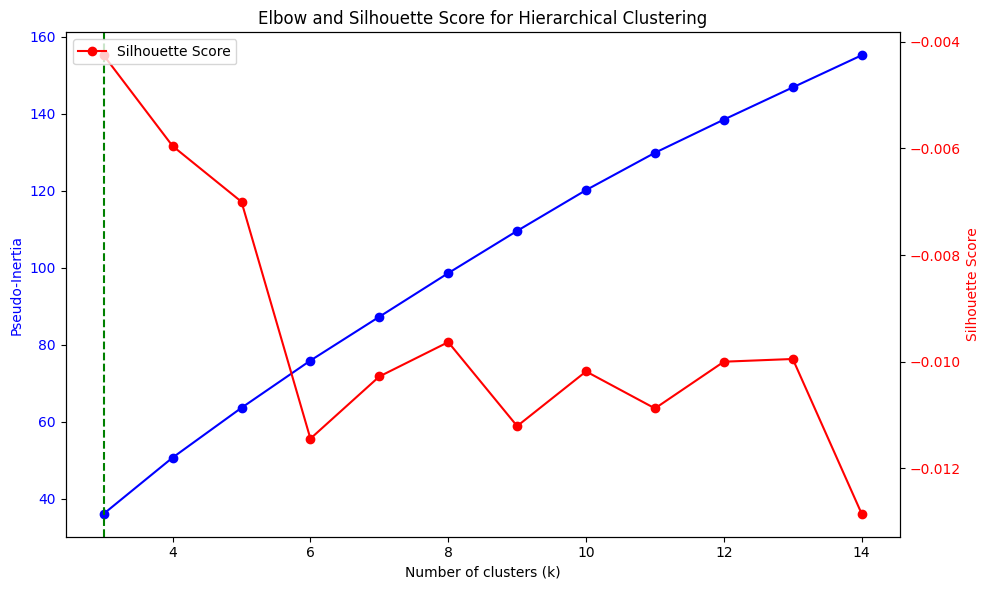

In [ ]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import linkage
from kneed import KneeLocator
import matplotlib.pyplot as plt
import numpy as np

k_values = range(3, 15)
pseudo_inertia = []
silhouette_scores = []

# Calculate scores for each k
for k in k_values:
    hier_model = AgglomerativeClustering(n_clusters=k, linkage='ward')
    labels = hier_model.fit_predict(embeddings)
    silhouette_scores.append(silhouette_score(embeddings, labels))
    linkage_matrix = linkage(embeddings, method='ward')
    pseudo_inertia.append(np.sum(linkage_matrix[-(k-1):, 2]))

# KneeLocator
knee_locator = KneeLocator(k_values, pseudo_inertia, curve='convex', direction='decreasing')
optimal_k_elbow = knee_locator.knee

# Plot pseudo-inertia (Elbow method) and silhouette scores
fig, ax1 = plt.subplots(figsize=(10, 6))
ax1.plot(k_values, pseudo_inertia, 'b-o', label='Pseudo-Inertia ', color='blue')
ax1.set_xlabel('Number of clusters (k)')
ax1.set_ylabel('Pseudo-Inertia', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax2 = ax1.twinx()
ax2.plot(k_values, silhouette_scores, 'r-o', label='Silhouette Score', color='red')
ax2.set_ylabel('Silhouette Score', color='red')
ax2.tick_params(axis='y', labelcolor='red')

if optimal_k_elbow is not None:
    ax1.axvline(x=optimal_k_elbow, color='green', linestyle='--', label=f'Optimal k (Elbow) = {optimal_k_elbow}')

# Plot
plt.title('Elbow and Silhouette Score for Hierarchical Clustering')
fig.tight_layout()
plt.legend(loc='upper left')
plt.show()


Using a small k based on the KneeLocator might not result in well-defined clusters. k value of 5 appears to be the best choice, with a balanced lower Pseudo-Inertia and higher Silhouette Score.

In [ ]:
# Manually choosing the best k from above plot
optimal_k_elbow = 5
hier_model_final = AgglomerativeClustering(n_clusters=optimal_k_elbow, linkage='ward')
h_labels = hier_model_final.fit_predict(embeddings)

## Plot
visualizes the results of hierarchical clustering using t-SNE, a dimensionality reduction technique. Each data point (movie review) is plotted, and colors represent the clusters assigned by hierarchical clustering.

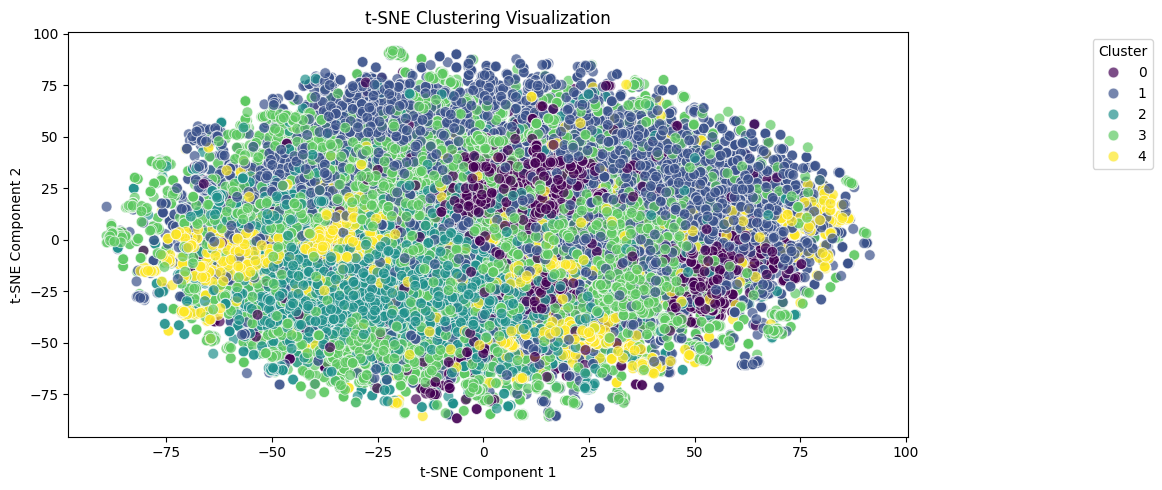

In [ ]:
tsne = TSNE(n_components=2, random_state=42)
embeddings_array = np.array(embeddings)
tsne_embeddings = tsne.fit_transform(embeddings_array)

# Plot t-SNE
plt.figure(figsize=(12, 5))
sns.scatterplot(x=tsne_embeddings[:, 0], y=tsne_embeddings[:, 1], hue=h_labels, palette='viridis', s=60, alpha=0.7)
plt.title("t-SNE Clustering Visualization")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.legend(title="Cluster", loc='upper right', bbox_to_anchor=(1.3, 1))
plt.tight_layout()
plt.show()

## Word cloud
We used the same method as in K-Means to create word clouds for hierarchical clustering. These word clouds highlight the dominant words in each cluster, helping us evaluate how well the clusters are formed.

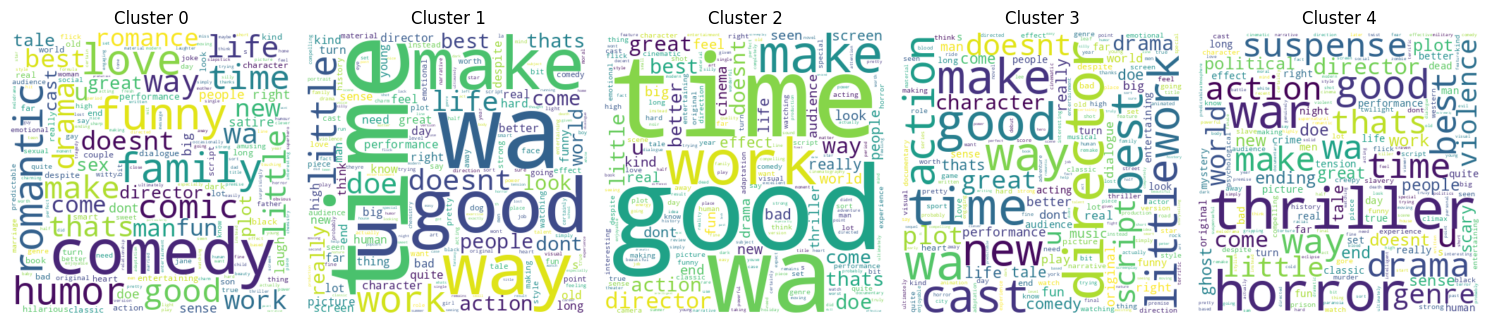

In [ ]:
# Remove custom stopwords
custom_stopwords = {'like', 'film', 'movie', 'story', 'just'}

# Word cloud for each cluster
clustered_reviews = pd.DataFrame({'review': review_cleaned, 'cluster': h_labels})
num_clusters = optimal_k_elbow
fig, axes = plt.subplots(1, num_clusters, figsize=(15, 6), sharex=True, sharey=True)

for cluster in range(num_clusters):
    cluster_reviews = clustered_reviews[clustered_reviews['cluster'] == cluster]['review']
    words = " ".join(cluster_reviews).split()
    word_freq = Counter(words)
    filtered_word_freq = {word: freq for word, freq in word_freq.items() if word not in custom_stopwords}
    wordcloud = WordCloud(width=400, height=400, background_color='white').generate_from_frequencies(filtered_word_freq)

    # Plot
    ax = axes[cluster]
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.axis('off')
    ax.set_title(f"Cluster {cluster}")

plt.tight_layout()
plt.show()

# Evaluation

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
import numpy as np

clustered_kmeans = pd.DataFrame({'review': review_cleaned, 'cluster': k_labels})
clustered_hierarchical = pd.DataFrame({'review': review_cleaned, 'cluster': h_labels})

# Top N words from each cluster using TF-IDF
def top_words(cluster_reviews, n=10):
    vectorizer = TfidfVectorizer( max_features=1000)
    X = vectorizer.fit_transform(cluster_reviews)
    terms = vectorizer.get_feature_names_out()
    scores = X.sum(axis=0).A1
    sorted_indices = scores.argsort()[::-1]
    top_word = [(terms[i], scores[i]) for i in sorted_indices[:n]]
    return top_word

n = 10
for cluster in range(optimal_k):
    kmeans_cluster_reviews = clustered_kmeans[clustered_kmeans['cluster'] == cluster]['review']
    print(f"K-Means Cluster {cluster} Top Words:", top_words(kmeans_cluster_reviews, n))
for cluster in range(optimal_k_elbow):
    hier_cluster_reviews = clustered_hierarchical[clustered_hierarchical['cluster'] == cluster]['review']
    print(f"Hierarchical Cluster {cluster} Top Words:", top_words(hier_cluster_reviews, n))


K-Means Cluster 0 Top Words: [('comedy', 125.9385306410296), ('funny', 82.00629909486793), ('humor', 64.79293374241523), ('movie', 55.89611238167997), ('like', 52.83260212238115), ('film', 51.62659628935763), ('just', 42.757625319152254), ('comic', 40.684691758511576), ('fun', 38.261806484008105), ('good', 38.22487642867652)]
K-Means Cluster 1 Top Words: [('film', 227.23388644765166), ('movie', 95.89655362702703), ('director', 86.72543608035119), ('like', 75.45795107073415), ('work', 69.14008001654047), ('make', 60.929581793198565), ('time', 57.097878157602835), ('just', 56.46373522643625), ('wa', 51.600569281114474), ('good', 50.16321832139637)]
K-Means Cluster 2 Top Words: [('movie', 253.21425247853196), ('film', 234.22407874266185), ('like', 111.48211643485479), ('good', 83.64494234975024), ('just', 83.17878042014829), ('wa', 73.58470464162835), ('story', 69.1066284792055), ('best', 66.55247865968458), ('time', 64.32451163055153), ('director', 60.15860743663222)]
K-Means Cluster 3 T

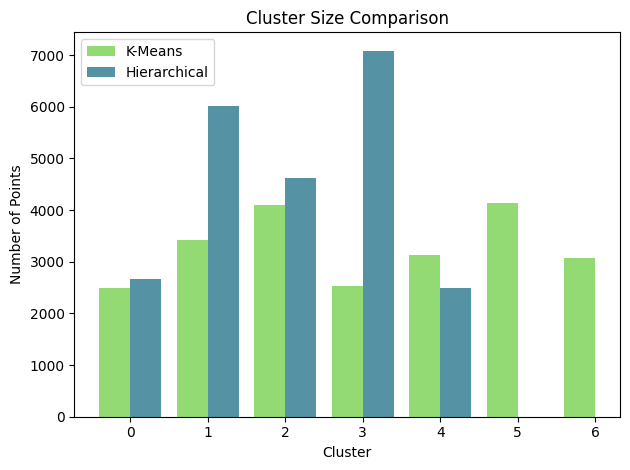

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Cluster sizes comparison for K-Means and Hierarchical Clustering
k_cluster_sizes = pd.Series(k_labels).value_counts().sort_index()
h_cluster_sizes = pd.Series(h_labels).value_counts().sort_index()
all_clusters = sorted(set(k_cluster_sizes.index).union(h_cluster_sizes.index))
k_aligned = k_cluster_sizes.reindex(all_clusters)
h_aligned = h_cluster_sizes.reindex(all_clusters)

# Plot
colors = sns.color_palette("viridis", n_colors=4)
plt.bar(np.arange(len(all_clusters)) - 0.4 / 2, k_aligned.values, width=0.4, color=colors[3], label="K-Means", alpha=0.8)
plt.bar(np.arange(len(all_clusters)) + 0.4 / 2, h_aligned.values, width=0.4, color=colors[1], label="Hierarchical", alpha=0.8)
plt.title("Cluster Size Comparison")
plt.xlabel("Cluster")
plt.ylabel("Number of Points")
plt.xticks(np.arange(len(all_clusters)), all_clusters)
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.metrics import silhouette_score

# Silhouette Score
print(f"Silhouette Score for K-Means: {silhouette_score(embeddings, k_labels)}")
print(f"Silhouette Score for Hierarchical Clustering: {silhouette_score(embeddings, h_labels)}")


Silhouette Score for K-Means: 0.008949439972639084
Silhouette Score for Hierarchical Clustering: -0.007001393940299749


In [ ]:
from sklearn.metrics import davies_bouldin_score

# Davies-Bouldin Index
print(f"Davies-Bouldin Index for K-Means: {davies_bouldin_score(embeddings, k_labels)}")
print(f"Davies-Bouldin Index for Hierarchical Clustering: {davies_bouldin_score(embeddings, h_labels)}")


Davies-Bouldin Index for K-Means: 5.809910788031611
Davies-Bouldin Index for Hierarchical Clustering: 8.857966333819146


In [ ]:
from sklearn.metrics import calinski_harabasz_score

# Calinski-Harabasz Index
print(f"Calinski-Harabasz Index for K-Means: {calinski_harabasz_score(embeddings, k_labels)}")
print(f"Calinski-Harabasz Index for Hierarchical Clustering: {calinski_harabasz_score(embeddings, h_labels)}")


Calinski-Harabasz Index for K-Means: 312.2713399782665
Calinski-Harabasz Index for Hierarchical Clustering: 171.7952921438104


# Topic modeling
Topic modeling helps uncover hidden themes or topics in a collection of text data. In this project, it is used to analyze movie reviews and identify recurring themes like acting, cinematography, or direction

## Data Cleaning
Used spaCy for text preprocessing and part-of-speech tagging.To ensure that only meaningful words are used for topic modeling.Retained only nouns, verbs, adjectives, and adverbs, as these are the most meaningful for topic modeling. Removed non-alphabetic characters, URLs, and stopwords.Filtered out reviews that were either too short (less than 10 words) or too long (more than 50 words) to ensure quality input.

In [ ]:
!pip install spacy
!python -m spacy download en_core_web_sm
!pip install bertopic
!pip install pyLDAvis

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 82.3 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.7/143.7 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 53.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 25.1 MB/s eta 0:00:00


In [ ]:
import spacy
import pandas as pd
import re
import nltk
from nltk.corpus import words
from nltk.stem import WordNetLemmatizer

nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('words')
nltk.download('punkt')
# Load spaCy English model
nlp = spacy.load("en_core_web_sm")

# Lemmatizer and English words
lemmatizer = WordNetLemmatizer()
english_words_set = set(words.words())

def clean_text_with_spacy(text):
    if not isinstance(text, str) or pd.isnull(text):
        return None

    text = text.lower()
    text = re.sub(r'http\S+|www.\S+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()

    # Text with spaCy
    doc = nlp(text)

    # Lemmatize words and keep only nouns, verbs, adjectives
    important_words = []
    for token in doc:
        if token.pos_ in ['NOUN', 'VERB', 'ADJ', 'ADV']:
            lemmatized_word = lemmatizer.lemmatize(token.text)
            if lemmatized_word in english_words_set:  # Keep valid English words
                important_words.append(lemmatized_word)

    cleaned_text = " ".join(important_words)

    # Sentences with more than 10 words or less than 50 words
    if len(important_words) < 10 or len(important_words) > 50:
        return None
    return cleaned_text

# Load the data
data_url = '/content/rotten_tomatoes_critic_reviews.csv'
review_raw_df = pd.read_csv(data_url).iloc[:90000]
review = review_raw_df['review_content']
review_cleaned = review.apply(clean_text_with_spacy).dropna()
print(review_cleaned.head())


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


0    fantasy adventure fuse mythology contemporary ...
3    audience get lightning thief hard predict over...
4    really lightning thief genuine sense wonder sa...
7    great movie good one kernel mythology so many ...
9    dragon fight thing squeeze few pause break fri...
Name: review_content, dtype: object


## LDA
LDA is a probabilistic topic modeling technique that assigns a distribution of topics to each document. It helps to discover coherent topics across the dataset. LDA creats a dictionary and Bag-of-Words (BoW) corpus.

- Perplexity Scores: Measures how well the model predicts the data (lower is better).
- Coherence Scores: Measures the semantic similarity of words in each topic (higher is better).

Used these scores to determine the optimal number of topics.

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


2
3
4
5
6
7
8
9
10
11
12
13
14
15


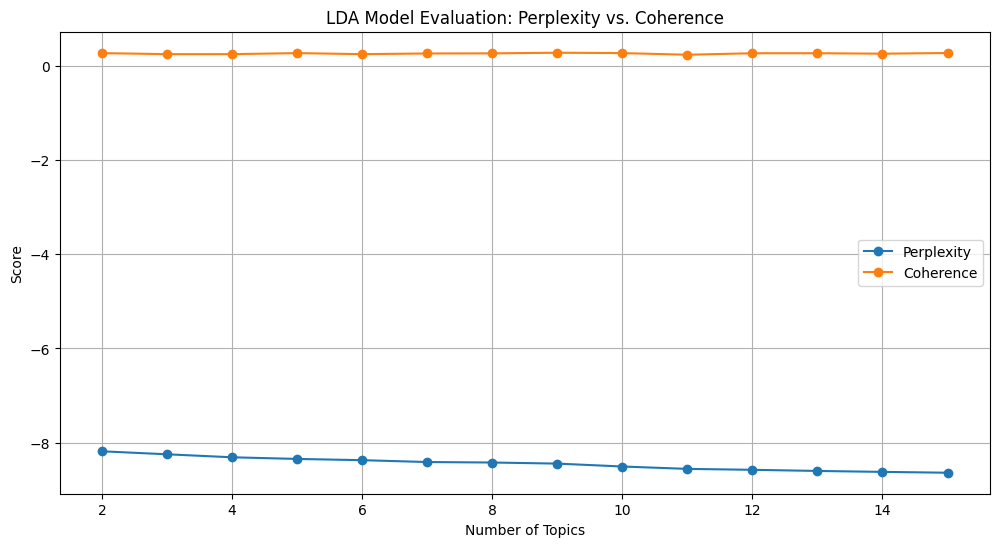

In [ ]:
import gensim
from gensim import corpora
import numpy as np
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from gensim.models import CoherenceModel

import nltk
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
nltk.download('punkt_tab')

# Tokenizing and removing stopwords
review_cleaned_list = review_cleaned.tolist()
tokenized_reviews_list = [[word for word in word_tokenize(review.lower()) if word not in stop_words] for review in review_cleaned_list]

# Create a dictionary & BOW corpus
dictionary = corpora.Dictionary(tokenized_reviews_list)
corpus = [dictionary.doc2bow(review) for review in tokenized_reviews_list]

# Perplexity and coherence scores
def evaluate_lda_model(corpus, dictionary, start=2, end=15):
    perplexity_scores = []
    coherence_scores = []

    for num_topics in range(start, end + 1):
        lda_model = gensim.models.LdaMulticore(corpus, num_topics=num_topics, id2word=dictionary, passes=20, iterations=500, workers=5)
        perplexity_scores.append(lda_model.log_perplexity(corpus))
        coherence_model = CoherenceModel(model=lda_model, texts=tokenized_reviews_list, dictionary=dictionary, coherence='c_v')
        coherence_scores.append(coherence_model.get_coherence())
        print(num_topics)
    return perplexity_scores, coherence_scores
perplexity_scores, coherence_scores = evaluate_lda_model(corpus, dictionary, start=2, end=15)

# Plot Perplexity and Coherence Scores
plt.figure(figsize=(12, 6))
plt.plot(range(2, 16), perplexity_scores, label='Perplexity', marker='o')
plt.plot(range(2, 16), coherence_scores, label='Coherence', marker='o')
plt.xlabel('Number of Topics')
plt.ylabel('Score')
plt.title('LDA Model Evaluation: Perplexity vs. Coherence')
plt.legend()
plt.grid(True)
plt.show()


Trained the LDA model with the optimal number of topics and visualized the results using PyLDAvis.

In [ ]:
import gensim
from gensim import corpora
import pyLDAvis
import pyLDAvis.gensim_models
import numpy as np
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

import nltk
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
nltk.download('punkt_tab')

# Train the LDA model
lda_model = gensim.models.LdaMulticore(corpus, num_topics=10, id2word=dictionary, passes=20, iterations=500, workers=5)
topic_distributions = lda_model.get_document_topics(corpus)

# Create topic probabilities matrix
topic_vectors = []

for doc_topics in topic_distributions:
    topic_vector = np.zeros(lda_model.num_topics)
    for topic_id, prob in doc_topics:
        topic_vector[topic_id] = prob
    topic_vectors.append(topic_vector)
topic_vectors = np.array(topic_vectors)

# KMeans clustering
kmeans = KMeans(n_clusters=5, random_state=42)
kmeans.fit(topic_vectors)
labels = kmeans.labels_

# Visualize the topics with PyLDAvis
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary, R=15)
pyLDAvis.display(vis)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


## BERTopic
BERTopic is an advanced topic modeling technique that combines topic modeling with embeddings from transformer models like Sentence-BERT. It provides more granular and meaningful topics compared to LDA. We used the all-MiniLM-L6-v2 Sentence-Transformer model to generate embeddings for each review. Applied BERTopic to cluster these embeddings and generate topics.

Visualized the topics using a bar chart showing the most relevant words for each topic.

In [ ]:
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
import pandas as pd

# Sentence-Transformer Model
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")

# BERTopic model
topic_model = BERTopic(embedding_model=embedding_model, language="english")
documents = review_cleaned.tolist()
topics, probs = topic_model.fit_transform(documents)

# Print the top topics
print(topic_model.get_topic_info())
topic_model.visualize_topics()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


     Topic  Count                                       Name  \
0       -1  12715                      -1_film_movie_more_so   
1        0    493                  0_comedy_laugh_joke_humor   
2        1    290                   1_actor_role_cast_talent   
3        2    277                 2_music_song_musical_dance   
4        3    250                3_horror_scary_zombie_scare   
..     ...    ...                                        ...   
149    148     11           148_screen_shaft_delete_forcibly   
150    149     11            149_trait_suck_drawing_eventful   
151    150     11  150_jerry_belatedly_attached_structurally   
152    151     10          151_aloofness_hatter_buoy_portman   
153    152     10         152_psychic_guess_corker_underling   

                                        Representation  \
0    [film, movie, more, so, character, make, story...   
1    [comedy, laugh, joke, humor, funny, laughter, ...   
2    [actor, role, cast, talent, acting, talented, ...   

2024-11-28 02:21:01,095 - BERTopic - WARNING: When you use `pickle` to save/load a BERTopic model,please make sure that the environments in which you saveand load the model are **exactly** the same. The version of BERTopic,its dependencies, and python need to remain the same.


In [ ]:
topic_model.visualize_barchart()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

